In [1]:
#import gdown
import os
import random
import nibabel as nib
import numpy as np
import pandas as pd
from glob import glob
import fnmatch
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
from skimage import color
from tqdm.auto import tqdm
import sys
plt.rcParams["figure.figsize"] = (10, 10)



# neural imaging
import nilearn as nl
import nibabel as nib


#Manejo de archivos
import shutil

#Semilla
torch.manual_seed(478)

/opt/conda/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


#### Pendientes
-DataOrder() --> poner details en el plot y plot image details

## Funciones

In [2]:
class DataOrder():
    def __init__(self, InputFolder,Pattern,OutputFolder):
        self.InputFolder=InputFolder
        self.Pattern=Pattern
        self.OutputFolder=OutputFolder
        self.files=[]
        self.OuputPath=[]
        
        #Ejecutar 
        self.GetData()
        self.CreateFolder()
        print("Starting copy")
        for f in self.files:
            self.OuputPath.append(self.CopyFiles(f))
        print("Copy Finished")
        
        
    def GetData(self): 
        for root, _, filenames in os.walk(self.InputFolder):
            for filename in fnmatch.filter(filenames,self.Pattern):
                self.files.append(os.path.join(root, filename))
        self.files.sort()

    def CopyFiles(self,FilePath):
        file=os.path.basename(os.path.normpath(FilePath))
        OutputFile=os.path.join(self.OutputFolder, file)
        
        src_path = FilePath
        dst_path = OutputFile
        shutil.copy(src_path, dst_path)
        return dst_path

    def CreateFolder(self):
        if os.path.exists(self.OutputFolder):
            shutil.rmtree(self.OutputFolder)
        os.makedirs(self.OutputFolder)
        
    def GetPaths(self):
        return self.OuputPath
    
    def ImagePlot(self,slice_w=30,subject=0):
        img = nib.load(self.OuputPath[subject]).get_fdata()
        plt.imshow(img[:,:,(img.shape[2]//2)-slice_w], cmap = 'gray')
        plt.show()
    
            
    #def CompleteJob(self):
        #final=[]
        #self.GetData()
        #self.CreateFolder()
        #print("Starting copy")
        #for f in self.files:
            #final.append(self.CopyFiles(f))
        #print("Copy Finished")
        #return final
        
        
        

In [3]:
class ImageDataset(Dataset):
    def __init__(self,root, transform=None, mode='train'):
        self.root_T1=root[0]
        self.root_T2=root[1]
        self.transform = transform
        self.files_T1 = sorted(glob(self.root_T1 + '/*.*'))
        self.files_T2 = sorted(glob(self.root_T2+ '/*.*'))
        if len(self.files_T1) > len(self.files_T2):
            self.files_T1, self.files_T2 = self.files_T2, self.files_T1
        self.new_perm()
        assert len(self.files_T1) > 0, "Make sure you loaded images correctly!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_T2))[:len(self.files_T1)]

    def __getitem__(self, index):
        
        T1_object=np.array(nib.load(self.files_T1[index % len(self.files_T1)]).get_fdata())
        T2_object=np.array(nib.load(self.files_T2[self.randperm[index]]).get_fdata())
        
        #Vamos a meterle un arreglito - voy a obtener solo las imagenes de enmedio relevantes.
        start_T1=T1_object.shape[2]//2
        start_T2=T2_object.shape[2]//2
        window_size=25

        T1_object=T1_object[:,:,start_T1-window_size:start_T1+window_size]
        T2_object=T2_object[:,:,start_T2-window_size:start_T2+window_size]
        
        #Carga de imagenes
        for t1_i in range(0,T1_object.shape[2]):
            item_T1 = self.transform(T1_object[:,:,t1_i])
        
        for t2_i in range(0,T2_object.shape[2]):
            item_T2 = self.transform(T2_object[:,:,t2_i])
        
        #if item_T1.shape[0] != 3: 
            #item_T1 = item_T1.repeat(3, 1, 1)
        #if item_T2.shape[0] != 3: 
            #item_T2 = item_T2.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        return (item_T1 - 0.5) * 2, (item_T2 - 0.5) * 2

    def __len__(self):
        return min(len(self.files_T1), len(self.files_T2))

# Load files

### Move files

In [4]:
InputFolder='../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
T1=DataOrder(InputFolder,"*_t1.nii",'/kaggle/working/Training/T1')
T2=DataOrder(InputFolder,"*_t2.nii",'/kaggle/working/Training/T2')

Starting copy
Copy Finished
Starting copy
Copy Finished


### Check files

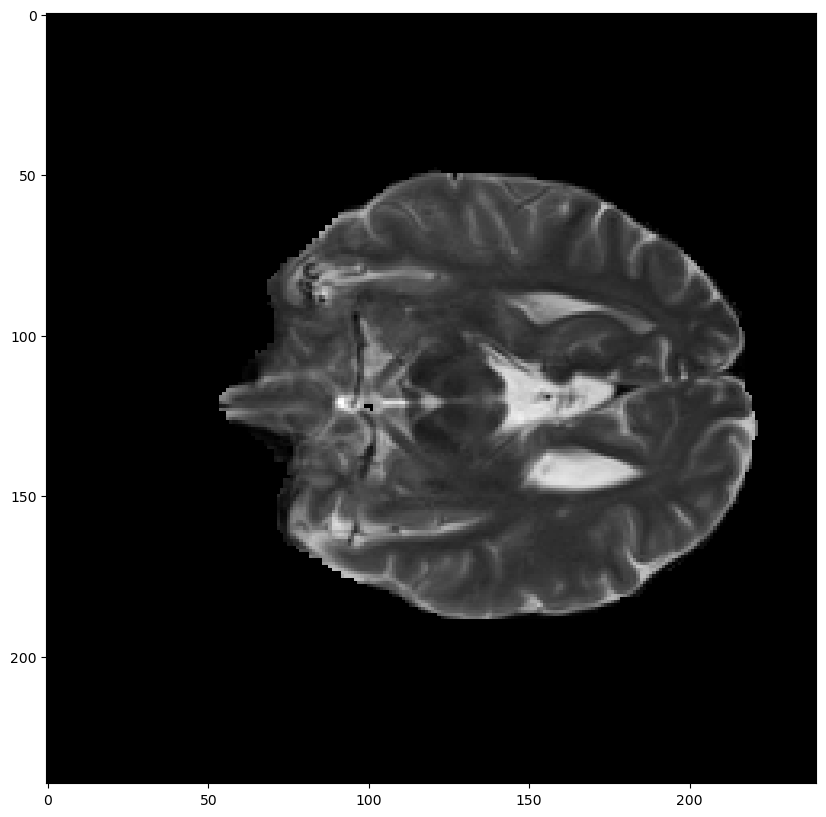

In [5]:
T2.ImagePlot(slice_w=25,subject=1)

In [6]:
T1_Path=T1.GetPaths()
np.array(nib.load(T1_Path[0]).get_fdata()).shape

(240, 240, 155)

# Model Creation

### Create Residuals blocks + Enconder blocks + Decoder blocks

In [7]:
def rename_attribute(obj, old_name, new_name):
    obj._modules[new_name] = obj._modules.pop(old_name)
    
    
class ResBlock(nn.Module):
    '''
    ResBlock Class:
    2 convolutions and an instance normalization.
    The input is added to this output to form the residual block output.
    
    Inputs:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels,kernel_size=3,padding=1,padding_mode='reflect',dropOut=None):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, 
                              input_channels, 
                              kernel_size=kernel_size, 
                              padding=padding, 
                              padding_mode=padding_mode)
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()
        if dropOut: self.DropOut=nn.Dropout(dropOut) 
        else: self.DropOut=None
        

    def forward(self, x):
        '''
            x: image tensor of shape (batch size, channels, height, width)
        '''
        original_x = x.clone()
        x = self.conv(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        if  self.DropOut: x =self.DropOut(x)
        x = self.conv(x)
        x = self.instancenorm(x)
        return original_x + x
    
    
class EncoderBlock(nn.Module):
    
    '''
        Function to create each block of the Encoder part.
        
        Given an image tensor witk k size apply a encoder block and returns the transformed tensor with k/2 size
        Performs a convolution followed by a max pool operation and an optional instance norm.
        
        Inputs
        input_channels: the number of channels to expect from a given input
        kernel_size
        padding
        padding_mode
        stride
        activation
        dropOut
        use_in
    '''
    
    def __init__(self, input_channels,kernel_size=3,padding=1,padding_mode='reflect',stride=2,activation ='relu',dropOut=None,use_in=True):
        super(EncoderBlock, self).__init__()
        
        # the number of filters in the last conv layer
        self.nfl=input_channels * 2
        self.conv = nn.Conv2d(input_channels, 
                              self.nfl, 
                              kernel_size=kernel_size, 
                              padding=padding, 
                              stride=stride, 
                              padding_mode=padding_mode)
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_in: self.instancenorm = nn.InstanceNorm2d(self.nfl)
        self.use_in = use_in

    def forward(self, x):
        '''
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        if self.use_in:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x
    
class DecoderBlock(nn.Module):
    '''
        Function to create each block of the Decoder part.
        
        Given an image tensor witk k size apply a encoder block and returns the transformed tensor with k*2 size

        
        Inputs
        input_channels: the number of channels to expect from a given input
        kernel_size
        padding
        output_padding
        padding_mode
        stride
        activation
        dropOut
        use_in
    '''
        
    def __init__(self, input_channels,kernel_size=3,padding=1,output_padding=1,stride=2, activation ='relu',dropOut= None, use_in=True):
        super(DecoderBlock, self).__init__()
        self.nfl=input_channels //  2
        self.Transconv = nn.ConvTranspose2d(input_channels, 
                                            self.nfl, 
                                            kernel_size=kernel_size, 
                                            padding=padding, 
                                            stride=stride, 
                                            output_padding=output_padding)
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_in: self.instancenorm = nn.InstanceNorm2d(self.nfl)
        self.use_in = use_in
        
       
    def forward(self, x):
        '''
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.Transconv(x)
        if self.use_in:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x
        
class FC(nn.Module):
    def __init__(self, input_channels,hidden_channels,kernel_size=7,padding=1,padding_mode='reflect',stride=2,activation="relu",Norm=True):
        super(FC, self).__init__()
        self.conv=nn.Conv2d(input_channels, 
                  hidden_channels,
                  kernel_size=kernel_size,
                  padding=padding,
                  padding_mode=padding_mode,
                  stride=stride)
        if Norm: self.instancenorm= nn.InstanceNorm2d(hidden_channels)
        else: self.instancenorm=None
        
        if activation: 
            if activation=='relu':
                self.activation=nn.ReLU()
            else:
                self.activation=nn.LeakyReLU(0.2)
        else: self.activation=None
        
        
       
    def forward(self, x):
        '''
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        if  self.instancenorm: x = self.instancenorm(x)
        if  self.activation: x = self.activation(x)
        return x
    

### Create Generator

In [20]:
class Generator(nn.Module):
    '''
    Generator Class
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
        Parameters: Dictionary with parameters of all blocks
        nBlocks Number of residual blocks to implement
        hidden_channels: Number of filters in the last conv layer
    '''
    def __init__(self, input_channels, output_channels,Parameters, nBlocks=6, hidden_channels=64):
        super(Generator, self).__init__()    
        self.nBlocks=nBlocks
        Parm_c7s1_64=Parameters["Parm_c7s1_64"]
        Parm_c7s1_3=Parameters["Parm_c7s1_3"]
        Parm_d3k=Parameters["Parm_d3k"]
        Parm_Rk=Parameters["Parm_Rk"]
        Parm_u3k=Parameters["Parm_u3k"]
        
        
        ####################################### Feature Map  ######################################
        #denote a7×7Convolution-InstanceNorm-ReLU layer withkfilters and stride1   
        
        
        
        self.c7s1_64 = FC(input_channels,
                           hidden_channels,
                           kernel_size=Parm_c7s1_64["kernel_size"],
                           padding=Parm_c7s1_64["padding"],
                           padding_mode=Parm_c7s1_64["padding_mode"],
                           stride=Parm_c7s1_64["stride"],
                           activation=Parm_c7s1_64["activation"],
                           Norm=Parm_c7s1_64["Norm"])
      
        
        
        ####################################### Downsampling ######################################
        # d3k denotes a 3×3C onvolution-InstanceNorm-ReLU  layer  withkfilters  and stride 2
        
        self.d3k_1 = EncoderBlock(hidden_channels,
                                 kernel_size=Parm_d3k["kernel_size"],
                                 padding=Parm_d3k["padding"],
                                 padding_mode=Parm_d3k["padding_mode"],
                                 stride=Parm_d3k["stride"],
                                 activation =Parm_d3k["activation"],
                                 dropOut=Parm_d3k["dropOut"],
                                 use_in=Parm_d3k["use_in"])
        
        self.d3k_2 = EncoderBlock(hidden_channels* 2,
                                 kernel_size=Parm_d3k["kernel_size"],
                                 padding=Parm_d3k["padding"],
                                 padding_mode=Parm_d3k["padding_mode"],
                                 stride=Parm_d3k["stride"],
                                 activation =Parm_d3k["activation"],
                                 dropOut=Parm_d3k["dropOut"],
                                 use_in=Parm_d3k["use_in"])
        
        
        ####################################### Residual ######################################
        #Rk denotes a residual block that contains two 3×3con-volutional 
        #layers with the same number of filters on bothlayer.
        
        mult = 4
        self.RestLayers = nn.ModuleDict(
            {f"res_{i}": ResBlock(hidden_channels * mult,
                                     Parm_Rk["kernel_size"],
                                     Parm_Rk["padding"],
                                     Parm_Rk["padding_mode"],
                                     Parm_Rk["dropOut"]) 
             for i in range(nBlocks)})
            
            

        ####################################### Decoder ######################################       
        self.u3k_1 = DecoderBlock(hidden_channels * 4,
                                      kernel_size=Parm_u3k["kernel_size"],
                                      padding=Parm_u3k["padding"],
                                      output_padding=Parm_u3k["output_padding"],
                                      stride=Parm_u3k["stride"], 
                                      activation =Parm_u3k["activation"],
                                      dropOut= Parm_u3k["dropOut"], 
                                      use_in=Parm_u3k["use_in"])
        
        self.u3k_2 = DecoderBlock(hidden_channels * 2,
                                      kernel_size=Parm_u3k["kernel_size"],
                                      padding=Parm_u3k["padding"],
                                      output_padding=Parm_u3k["output_padding"],
                                      stride=Parm_u3k["stride"], 
                                      activation =Parm_u3k["activation"],
                                      dropOut= Parm_u3k["dropOut"], 
                                      use_in=Parm_u3k["use_in"])
        
        ####################################### Feature Map  ######################################
        self.c7s1_3 = FC(input_channels,
                           hidden_channels,
                           kernel_size=Parm_c7s1_3["kernel_size"],
                           padding=Parm_c7s1_3["padding"],
                           padding_mode=Parm_c7s1_3["padding_mode"],
                           stride=Parm_c7s1_3["stride"],
                           activation=Parm_c7s1_3["activation"],
                           Norm=Parm_c7s1_3["Norm"])
        
        ####################################### Activation  ######################################
        self.tanh = nn.Tanh()

    def forward(self, x):
        '''
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''    
        x = self.c7s1_64(x)
        
        x = self.d3k_1(x)
        x = self.d3k_2(x)
        
        for i in range(self.nBlocks):
            x = self.RestLayers[f"res_{i}"](x)
        
        x = self.u3k_1(x)
        x = self.u3k_2(x)
        
        x=self.tanh(x)
        
        return x  
    

### Create Discriminator

In [21]:
 class Discriminator(nn.Module):
    '''
    The discriminator yields  a matrix of values classifying corresponding 
    portions of the image as real or fake. 
    
    Based on the CycleGan Paper: https://arxiv.org/abs/1703.10593
    For   discriminator   net-works, we use 70×70 PatchGAN.  
    Let Ck denote a 4×4 Convolution-InstanceNorm-LeakyReLU layer with k filters and stride2.
    After the last layer, we apply a convo-lution to produce a 1-dimensional output.   
    We do not use InstanceNorm for the first C64 layer. We use leaky ReLUs with a slope of 0.2. 
    The discriminator architecture is:C64-C128-C256-C512

    
    
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
        n_layers number of layers to implement
    '''
    def __init__(self, input_channels, Parameters, hidden_channels=64, n_layers=3):
        super(Discriminator, self).__init__()
        
        #No more than 8 layers
        if n_layers>=8:
            n_layers=8
        
        #Parameters
        upfeaturing=Parameters["upfeaturing"]
        CK=Parameters["CK"]
        CV=Parameters["CV"]
        
        
        
        #Layers First
        self.upfeaturing=FC(input_channels,
                           hidden_channels,
                           kernel_size=upfeaturing["kernel_size"],
                           padding=upfeaturing["padding"],
                           padding_mode=upfeaturing["padding_mode"],
                           stride=upfeaturing["stride"],
                           activation=upfeaturing["activation"],
                           Norm=upfeaturing["Norm"])
    #Layers contracting
        self.CK = nn.ModuleDict(
            {f"C_{hidden_channels*(2**n)*2}": EncoderBlock(hidden_channels*(2**n),
                                 kernel_size=CK["kernel_size"],
                                 padding=CK["padding"],
                                 padding_mode=CK["padding_mode"],
                                 stride=CK["stride"],
                                 activation =CK["activation"],
                                 dropOut=CK["dropOut"],
                                 use_in=CK["use_in"])
             for n in range(0,n_layers)})
        

        
        self.CV  =      FC(hidden_channels*(2**n_layers),
                           1,
                           kernel_size=CV["kernel_size"],
                           padding=CV["padding"],
                           padding_mode=CV["padding_mode"],
                           stride=CV["stride"],
                           activation=CV["activation"],
                           Norm=CV["Norm"])

    def forward(self, x):
        x = self.upfeaturing(x)
        x = self.CK(x)
        x = self.CV (x)
        return x

### Compute Backward and loss

In [22]:
def D_Loss(real_X,real_Y,gen_YX,disc_X,lsgan,D_X_opt):
    """Calculate GAN loss for the discriminator
        Parameters:
            netD (network)      -- the discriminator D
            real (tensor array) -- real images
            fake (tensor array) -- images generated by a generator
        Return the discriminator loss.
        We also call loss_D.backward() to calculate the gradients.
    """
    # Zero out the gradient before backpropagation
    D_X_opt.zero_grad() 
    with torch.no_grad():
        fake_X = gen_YX(real_Y)
    
    #Compute loss using MSE
    Pr_fake=disc_X(fake_X.detach())
    l_fake=lsgan(Pr_fake, torch.zeros_like(Pr_fake))
    
    Pr_real=disc_X(real_X)
    l_real=lsgan(Pr_real, torch.ones_like(Pr_real))
    disc_loss = (l_fake + l_real) / 2
        
    #Backward propagation
    disc_loss.backward(retain_graph=True) # Update gradients
    disc_loss.step() # Update optimizer
    
    return disc_loss


def G_IdentityLoss(real_X,gen_YX,L1Loss):
    I_X=gen_YX(real_X)
    identity_loss=identity_criterion(I_X,real_X)
    return identity_loss, I_X
    
    
def G_CycleLoss(real_X,fake_Y,gen_YX,L1Loss):
    #### START CODE HERE ####
    CycleFake_X=gen_YX(fake_Y)
    cycle_loss=L1Loss(CycleFake_X,real_X)
    return cycle_loss, CycleFake_X

def G_Loss_Adverserial(real_X,disc_Y,gen_XY,lsAdv):
    #Adverserial loss
    fake_Y=gen_XY(real_X)
    Pr_fake=disc_Y(fake_Y)
    adversarial_loss=lsAdv(Pr_fake, torch.ones_like(Pr_fake))
    return fake_Y,adversarial_loss

def G_Loss(real_X,real_Y,disc_X,disc_Y,gen_XY,gen_YX,lsAdv,CycleL1,IdentityL1,lambdas):
    
    #Lambdas
    lambdaI=lambdas["I"]
    lambdaCX=lambdas["CX"]
    lambdaCY=lambdas["CY"]
    
    # GAN loss D_A(G_A(A))
    adv_XY, fake_Y=G_Loss_Adverserial(real_X, disc_Y, gen_XY, lsAdv)
    adv_YX, fake_X=G_Loss_Adverserial(real_Y, disc_X, gen_YX, lsAdv)
    
    I_X,_=G_IdentityLoss(real_X,gen_YX,IdentityL1)
    I_Y,_=G_IdentityLoss(real_Y, gen_XY, IdentityL1)
    
    cyc_X, _=G_CycleLoss(real_X, fake_Y, gen_YX, CycleL1)
    cyc_Y, _=G_CycleLoss(real_Y, fake_X, gen_XY, CycleL1)

    # Total loss
    gen_loss=adv_XY+adv_YX+lambdaI*(I_X+I_Y)+lambdaCX*cyc_X+lambdaCY*cyc_Y
    T_loss={"adv":adv_XY+adv_YX,"cyc":lambdaCX*cyc_X+lambdaCY*cyc_Y,"Id":lambdaI*(I_X+I_Y)}
    
    if lambdaI:
        gen_loss=adv_XY+adv_YX+lambdaI*(I_X+I_Y)+lambdaCX*cyc_X+lambdaCY*cyc_Y

    return gen_loss, fake_X, fake_Y,T_loss

# Training - Loss Function

### Parameter Initialitation

In [23]:
################################### Generator Parameters ###############################################
Parm_c7s1_64={"kernel_size":7,
             "padding":1,
             "output_padding":1,
             "padding_mode":'reflect',
             "stride":2,
             "activation" :'relu',
             "Norm":True}


Parm_d3k={"kernel_size":3,
             "padding":1,
             "output_padding":1,
             "padding_mode":'reflect',
             "stride":2,
             "activation" :'relu',
             "dropOut":None,
             "use_in":True}


Parm_Rk={"kernel_size":3,
             "padding":1,
             "padding_mode":'reflect',
             "dropOut":None}


Parm_u3k={"kernel_size":3,
             "padding":1,
             "output_padding":1,
             "padding_mode":'reflect',
             "stride":2,
             "activation" :'relu',
             "dropOut":None,
             "use_in":True}


Parm_c7s1_3={ "kernel_size":7,
             "padding":1,
             "output_padding":1,
             "padding_mode":'reflect',
             "stride":2,
             "activation" : None,
             "Norm":False}

################################### Discriminator Parameters ###############################################

upfeaturing={ "kernel_size":4,
             "padding":1,
             "output_padding":1,
             "padding_mode":'reflect',
             "stride":2,
             "activation" :'lrelu',
             "Norm":False}


CK={   "kernel_size":4,
             "padding":1,
             "output_padding":1,
             "padding_mode":'reflect',
             "stride":2,
             "activation" :'lrelu',
             "dropOut":None,
             "use_in":True}

CV={ "kernel_size":4,
             "padding":1,
             "output_padding":1,
             "padding_mode":'reflect',
             "stride":1,
             "activation" :None,
             "Norm":False}

In [24]:
lsAdv = nn.MSELoss() 
L1Loss = nn.L1Loss() 

dim_T1 = 1
dim_T2 = 1
lr = 0.0002
device = 'cuda'

DParameters={"upfeaturing":upfeaturing,"CK":CK,"CV":CV}
GParameters={"Parm_c7s1_64":Parm_c7s1_64,"Parm_d3k":Parm_d3k,"Parm_Rk":Parm_Rk,"Parm_u3k":Parm_u3k,"Parm_c7s1_3":Parm_c7s1_3}
lambdas={"I":0.1,"lambdaCX":10,"lambdaCY":10}

G_T12 = Generator(dim_T1, dim_T2, GParameters, nBlocks=6, hidden_channels=64).to(device)
G_T21 = Generator(dim_T2, dim_T2, GParameters, nBlocks=6, hidden_channels=64).to(device)
G_opt = torch.optim.Adam(list(G_T12.parameters()) + list(G_T21.parameters()), lr=lr, betas=(0.5, 0.999))

D_T2 = Discriminator(dim_T2, DParameters, hidden_channels=64, n_layers=3).to(device)
D_T2_opt = torch.optim.Adam(D_T2.parameters(), lr=lr, betas=(0.5, 0.999))
D_T1 = Discriminator(dim_T1, DParameters, hidden_channels=64, n_layers=3).to(device)
D_T1_opt = torch.optim.Adam(D_T1.parameters(), lr=lr, betas=(0.5, 0.999))

In [25]:
# Parameters
avgG_loss,avgD_loss = 0,0
TavgG_loss,TavgD_loss = [],[]
step         = 0
display      = 50
save_m       = 2
n_epochs     = 8
display_step = 200
load_shape   = 240
target_shape = 256
batch_size   = 5

transform    = transforms.Compose([
    transforms.ToTensor()])

dataset      = ImageDataset(['/kaggle/working/Training/T1','/kaggle/working/Training/T2'], transform=transform)

#Test el data loader
dataloader   = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Comienza el training")
for epoch in range(n_epochs):
    print("\rEpoch {}/{}.".format(epoch,n_epochs), end="")
    sys.stdout.flush()
    
  # Return Batches and gaves me a completion %
    for real_T1, real_T2 in dataloader:
    
        real_T1 = nn.functional.interpolate(real_T1, size=target_shape).type(torch.FloatTensor).to(device)
        real_T2 = nn.functional.interpolate(real_T2, size=target_shape).type(torch.FloatTensor).to(device)

        ### Update discriminator T1 ###
        DT1_loss=D_Loss(real_T1,real_T2,G_T21,D_T1,lsAdv,D_T1_opt)

        ### Update discriminator T2 ###
        DT2_loss=D_Loss(real_T2,real_T1,G_T12,D_T2,lsAdv,D_T2_opt)

        ### Update generator ###
        gen_opt.zero_grad()
        G_loss, fake_T1, fake_T2,T_loss=G_Loss(real_T1,real_T2,D_T1,D_T2,G_T12,G_T21,lsAdv,L1Loss,L1Loss,lambdas)
        G_loss.backward() # Update gradients
        G_loss.step() # Update optimizer

        
        # Keep track of the average discriminator loss
        avgD_loss += DT2_loss.item() 
        # Keep track of the average generator loss
        avgG_loss += G_loss.item()
        
        
        if i % 10 == 0:
            print("\rBatch {}/{}.".format(i,len(dataloader)), end="")
            sys.stdout.flush()

        #Save and plot
        if step % display == 0:
            print(f"Epoch {epoch}: Step {step}: Generator loss: {avgG_loss}, Discriminator loss: {avgD_loss}")
            show_tensor_images(torch.cat([real_T1, real_T2]), size=(dim_T1, target_shape, target_shape))
            show_tensor_images(torch.cat([fake_T2, fake_T1]), size=(dim_T2, target_shape, target_shape))
       
        step+=1
          
    # You can change save_model to True if you'd like to save the model
    TavgG_loss.append(np.mean(avgG_loss))
    TavgD_loss.append(np.mean(avgD_loss))
    
    if save_model & (epoch % save_m == 0):
        torch.save({
                    'gen_AB': gen_AB.state_dict(),
                    'gen_BA': gen_BA.state_dict(),
                    'gen_opt': gen_opt.state_dict(),
                    'disc_A': disc_A.state_dict(),
                    'disc_A_opt': disc_A_opt.state_dict(),
                    'disc_B': disc_B.state_dict(),
                    'disc_B_opt': disc_B_opt.state_dict(),
                    'Mean_G_loss':TavgG_loss,
                    'Mean_DT2_loss':TavgD_loss
        }, f"/kaggle/working/cycleGAN_{epoch}.pth")


Comienza el training
Epoch 0/8.

RuntimeError: Given groups=1, weight of size [64, 1, 4, 4], expected input[5, 64, 130, 130] to have 1 channels, but got 64 channels instead